In [71]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Loading Data from CSV file

In [3]:
#Saumya Shah
#Jait Purohit

import sklearn.feature_extraction.text as sk_text
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from pandas import Series
%matplotlib inline
#reading json file into tabular format
import json
import csv
import pandas as pd

In [128]:
filename_read = 'network_intrusion_data.csv'
df = pd.read_csv(filename_read, na_values=['NA','?'])

In [129]:
df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome']

In [130]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
df.shape

(494020, 42)

# Data Exploration

In [8]:
for i in df.columns:
    print(i," ",len(df[i].unique()))

duration   2495
protocol_type   3
service   66
flag   11
src_bytes   3300
dst_bytes   10725
land   2
wrong_fragment   3
urgent   4
hot   22
num_failed_logins   6
logged_in   2
num_compromised   23
root_shell   2
su_attempted   3
num_root   20
num_file_creations   18
num_shells   3
num_access_files   7
num_outbound_cmds   1
is_host_login   1
is_guest_login   2
count   490
srv_count   470
serror_rate   92
srv_serror_rate   51
rerror_rate   77
srv_rerror_rate   51
same_srv_rate   99
diff_srv_rate   78
srv_diff_host_rate   64
dst_host_count   256
dst_host_srv_count   256
dst_host_same_srv_rate   101
dst_host_diff_srv_rate   101
dst_host_same_src_port_rate   101
dst_host_srv_diff_host_rate   65
dst_host_serror_rate   100
dst_host_srv_serror_rate   72
dst_host_rerror_rate   101
dst_host_srv_rerror_rate   101
outcome   23


In [131]:
df[df.isnull().any(axis=1)]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome


outcome


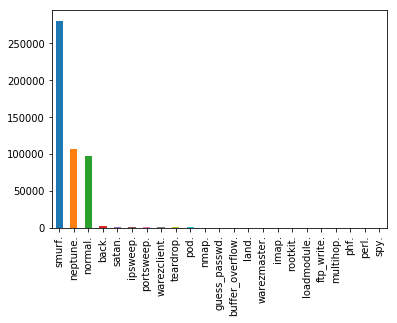

protocol_type


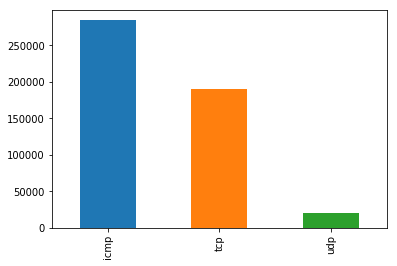

service


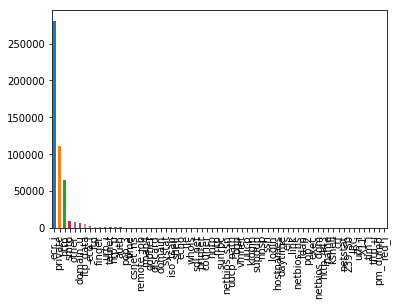

flag


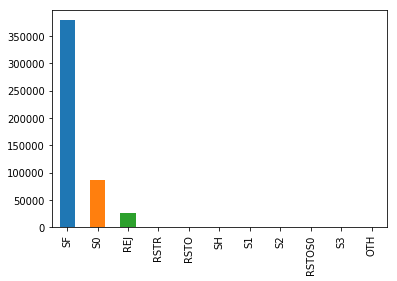

src_bytes


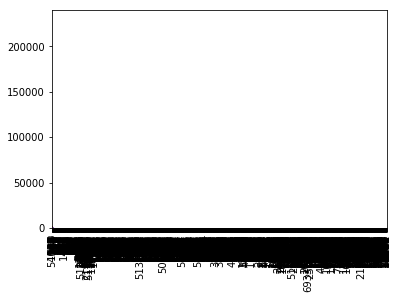

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
visuallist = ['outcome','protocol_type','service','flag','src_bytes']
for i in visuallist:
    print(i)
    df[i].value_counts().plot.bar()
    plt.show()

# Data Preprocessing

In [9]:
def labels_map(label):
    label = str(label).split('.')[0]
    if label == 'normal':
        return 0
    else:
        return 1
df['enc_outcome'] = df.outcome.apply(labels_map)

In [10]:
onehotcols = ['protocol_type','service','flag','land','logged_in','root_shell','is_host_login','is_guest_login',]

In [11]:
for i in onehotcols:
    encode_text_dummy(df,i)

In [12]:
df.shape

(494020, 124)

In [13]:
df_new = df

In [14]:
zscorecols = [
'duration',
'src_bytes',
'dst_bytes',
'hot',
'num_compromised',
'num_root',
'num_file_creations',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

In [15]:
for i in zscorecols:
    print(i," ",len(df[i].unique()))

duration   2495
src_bytes   3300
dst_bytes   10725
hot   22
num_compromised   23
num_root   20
num_file_creations   18
count   490
srv_count   470
serror_rate   92
srv_serror_rate   51
rerror_rate   77
srv_rerror_rate   51
same_srv_rate   99
diff_srv_rate   78
srv_diff_host_rate   64
dst_host_count   256
dst_host_srv_count   256
dst_host_same_srv_rate   101
dst_host_diff_srv_rate   101
dst_host_same_src_port_rate   101
dst_host_srv_diff_host_rate   65
dst_host_serror_rate   100
dst_host_srv_serror_rate   72
dst_host_rerror_rate   101
dst_host_srv_rerror_rate   101


In [16]:
for i in zscorecols:
    encode_numeric_zscore(df_new,i)

In [17]:
df_new.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,...,flag-SH,land-0,land-1,logged_in-0,logged_in-1,root_shell-0,root_shell-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002820,-0.011578,0,0,-0.044136,0,-0.005679,0,-0.00564,...,0,1,0,0,1,1,0,1,1,0
1,-0.067792,-0.002824,0.014179,0,0,-0.044136,0,-0.005679,0,-0.00564,...,0,1,0,0,1,1,0,1,1,0
2,-0.067792,-0.002840,0.014179,0,0,-0.044136,0,-0.005679,0,-0.00564,...,0,1,0,0,1,1,0,1,1,0
3,-0.067792,-0.002842,0.035214,0,0,-0.044136,0,-0.005679,0,-0.00564,...,0,1,0,0,1,1,0,1,1,0
4,-0.067792,-0.002842,0.035214,0,0,-0.044136,0,-0.005679,0,-0.00564,...,0,1,0,0,1,1,0,1,1,0


In [18]:
df_new['enc_outcome'].unique()

array([0, 1], dtype=int64)

In [19]:
df_new.shape

(494020, 124)

In [20]:
    df_new.drop(columns='outcome',inplace=True)

In [21]:
traincols = df_new.columns.tolist() 

In [22]:
traincols.remove('enc_outcome')

In [51]:
x_train, x_test, y_train, y_test = train_test_split(df_new[traincols],df_new['enc_outcome'], test_size=0.2, random_state=42)

# Logistic Regression

In [25]:
#Logistic Regression
from sklearn import metrics
logreg = LogisticRegression()
# fit the model with data
logreg.fit(x_train,y_train)
# predict the response for new observations
logisticprediction = logreg.predict(x_test)

In [26]:
print("Accuracy: ", metrics.accuracy_score(y_test,logisticprediction))
print("Precision: ", metrics.precision_score(y_test,logisticprediction, pos_label=1, average='weighted'))
print("Recall: ", metrics.recall_score(y_test,logisticprediction, pos_label=1, average='weighted'))
print("F1_Score: ", metrics.f1_score(y_test,logisticprediction, pos_label=1, average='weighted'))
print("Confusion Matrix: ", metrics.confusion_matrix(y_test,logisticprediction))

Accuracy:  0.998400874458524
Precision:  0.9984032405746215
Recall:  0.998400874458524
F1_Score:  0.998401653478205
Confusion Matrix:  [[19314    54]
 [  104 79332]]


In [72]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

[[19314    54]
 [  104 79332]]
Plotting confusion matrix


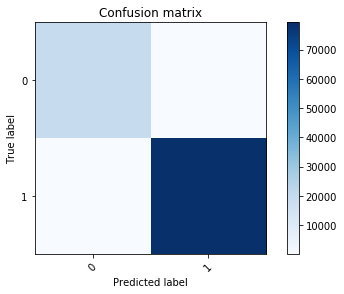

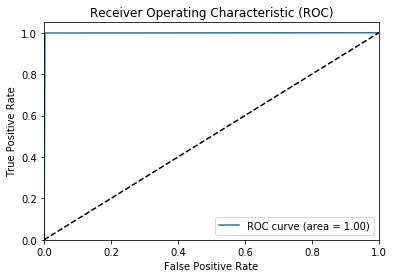

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



In [73]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, logisticprediction)
print(cm)
outcome = encode_text_index(df_new,'enc_outcome')

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
#pred = logisticprediction[:,1]
plot_roc(logisticprediction,y_test)
print(classification_report(y_test, logisticprediction))

# Nearest Neighbor

In [79]:
#Nearest Neighbor
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)
# predict the response for new observations
knnprediction = knn.predict(x_test)


Accuracy:  0.9994332213270718
Precision:  0.9994332447523526
Recall:  0.9994332213270718
F1_Score:  0.9994332323905865
Confusion Matrix:  [[19341    27]
 [   29 79407]]
[[19341    27]
 [   29 79407]]
Plotting confusion matrix


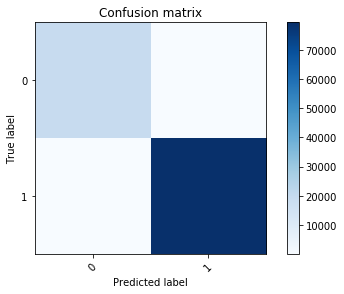

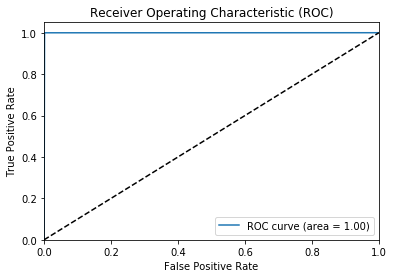

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



In [80]:
print("Accuracy: ", metrics.accuracy_score(y_test,knnprediction))
print("Precision: ", metrics.precision_score(y_test,knnprediction, pos_label=1, average='weighted'))
print("Recall: ", metrics.recall_score(y_test,knnprediction, pos_label=1, average='weighted'))
print("F1_Score: ", metrics.f1_score(y_test,knnprediction, pos_label=1, average='weighted'))
print("Confusion Matrix: ", metrics.confusion_matrix(y_test,knnprediction))
cm = confusion_matrix(y_test, knnprediction)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(knnprediction,y_test)
print(classification_report(y_test, knnprediction))

# Gaussian Naive Bayes

In [75]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train, y_train)
#GaussianNB(priors=None, var_smoothing=1e-09)
gnbprediction = clf.predict(x_test)

Accuracy:  0.9494757297275414
Precision:  0.9596545703017108
Recall:  0.9494757297275414
F1_Score:  0.9515202417326188
Confusion Matrix:  [[19339    29]
 [ 4963 74473]]
[[19339    29]
 [ 4963 74473]]
Plotting confusion matrix


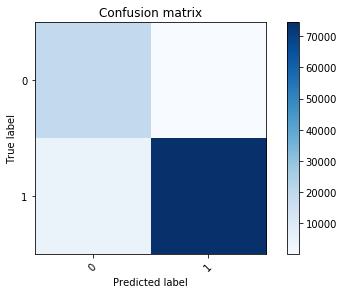

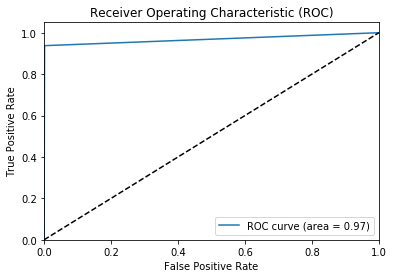

             precision    recall  f1-score   support

          0       0.80      1.00      0.89     19368
          1       1.00      0.94      0.97     79436

avg / total       0.96      0.95      0.95     98804



In [76]:
print("Accuracy: ", metrics.accuracy_score(y_test,gnbprediction))
print("Precision: ", metrics.precision_score(y_test,gnbprediction, pos_label=1, average='weighted'))
print("Recall: ", metrics.recall_score(y_test,gnbprediction, pos_label=1, average='weighted'))
print("F1_Score: ", metrics.f1_score(y_test,gnbprediction, pos_label=1, average='weighted'))
print("Confusion Matrix: ", metrics.confusion_matrix(y_test,gnbprediction))
cm = confusion_matrix(y_test, gnbprediction)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(gnbprediction,y_test)
print(classification_report(y_test, gnbprediction))


# Support Vector Machine

In [77]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(x_train, y_train)

svmprediction = clf.predict(x_test)

Accuracy:  0.99847172179264
Precision:  0.9984738358258299
Recall:  0.99847172179264
F1_Score:  0.9984724217043198
Confusion Matrix:  [[19316    52]
 [   99 79337]]
[[19316    52]
 [   99 79337]]
Plotting confusion matrix


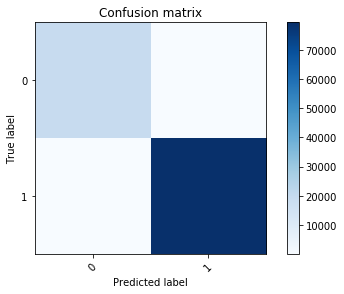

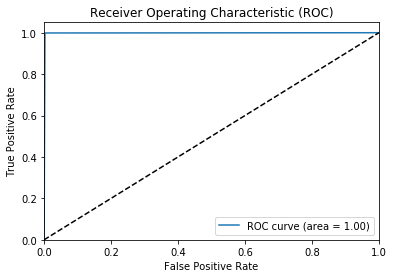

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



In [78]:
print("Accuracy: ", metrics.accuracy_score(y_test,svmprediction))
print("Precision: ", metrics.precision_score(y_test,svmprediction, pos_label=1, average='weighted'))
print("Recall: ", metrics.recall_score(y_test,svmprediction, pos_label=1, average='weighted'))
print("F1_Score: ", metrics.f1_score(y_test,svmprediction, pos_label=1, average='weighted'))
print("Confusion Matrix: ", metrics.confusion_matrix(y_test,svmprediction))
cm = confusion_matrix(y_test, svmprediction)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(svmprediction,y_test)
print(classification_report(y_test, svmprediction))

# Fully-Connected Neural Networks

In [29]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
import io
import requests
from sklearn import metrics

x,y = to_xy(df_new, 'enc_outcome')
x_train_ann_class, x_test_ann_class, y_train_ann_class, y_test_ann_class = train_test_split(x, y, test_size=0.25, random_state=42)
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_fairclass.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    model = Sequential()
    model.add(Dense(60, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
    model.add(Dense(45, activation='sigmoid')) # Hidden 2
    model.add(Dense(30, activation='sigmoid')) # Hidden 3
    model.add(Dense(2, activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model.fit(x_train_ann_class, y_train_ann_class, validation_data=(x_test_ann_class,y_test_ann_class), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

    

model.load_weights('dnn/best_weights_fairclass.hdf5')
pred = model.predict(x_test_ann_class)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test_ann_class,axis=1) 
score = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score))
print("Confusion Matrix: {}".format(metrics.confusion_matrix(y_true, pred)))

C:\Users\rutwi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 370515 samples, validate on 123505 samples
Epoch 1/100
 - 22s - loss: 0.0130 - val_loss: 0.0052
Epoch 2/100
 - 22s - loss: 0.0041 - val_loss: 0.0035
Epoch 3/100
 - 21s - loss: 0.0032 - val_loss: 0.0037
Epoch 4/100
 - 22s - loss: 0.0026 - val_loss: 0.0026
Epoch 5/100
 - 22s - loss: 0.0022 - val_loss: 0.0030
Epoch 6/100
 - 22s - loss: 0.0020 - val_loss: 0.0024
Epoch 7/100
 - 22s - loss: 0.0019 - val_loss: 0.0024
Epoch 8/100
 - 22s - loss: 0.0018 - val_loss: 0.0022
Epoch 9/100
 - 22s - loss: 0.0017 - val_loss: 0.0022
Epoch 10/100
 - 22s - loss: 0.0016 - val_loss: 0.0020
Epoch 11/100
 - 22s - loss: 0.0015 - val_loss: 0.0020
Epoch 00011: early stopping
Train on 370515 samples, validate on 123505 samples
Epoch 1/100
 - 30s - loss: 0.0124 - val_loss: 0.0046
Epoch 2/100
 - 27s - loss: 0.0042 - val_loss: 0.0032
Epoch 3/100
 - 22s - loss: 0.0031 - val_loss: 0.0029
Epoch 4/100
 - 22s - loss: 0.0026 - val_loss: 0.0025
Epoch 5/100
 - 22s - loss: 0.0022 - val_loss: 0.0025
Epoch 6/100
 - 22s

[[24256    29]
 [   35 99185]]
Plotting confusion matrix


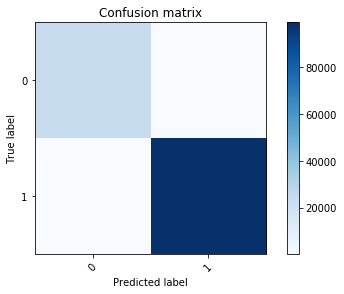

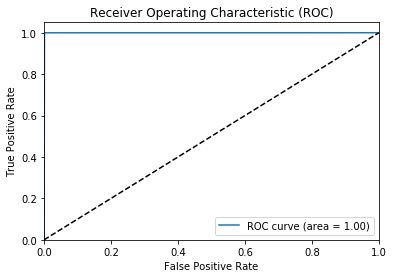

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     24285
          1       1.00      1.00      1.00     99220

avg / total       1.00      1.00      1.00    123505



In [74]:
cm = confusion_matrix(y_true, pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(pred,y_true)
print(classification_report(y_true, pred))

# Convolutional Neural Networks (CNN)

In [88]:
x,y = to_xy(df_new, 'enc_outcome')
x_train, x_test, y_train, y_test = train_test_split(df_new[traincols],df_new['enc_outcome'], test_size=0.2, random_state=42)

In [90]:
x_train = x_train.as_matrix()
x_test = x_test.as_matrix()

C:\Users\rutwi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\rutwi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [94]:
x_train = x_train.reshape(x_train.shape[0], 1, 122, 1)
x_test = x_test.reshape(x_test.shape[0], 1, 122, 1)

In [100]:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [101]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(395216, 1, 122, 1)
(395216, 2)
(98804, 1, 122, 1)
(98804, 2)


In [102]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 128
rows, cols = 1, 122
model = Sequential()
input_shape = (rows, cols, 1)
model.add(Conv2D(32, kernel_size=(1, 4), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(1,2)))
model.add(Conv2D(64, (1, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam")




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 1, 119, 32)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 59, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 56, 64)         8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 28, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               459008    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
__________

In [105]:
import time
start_time = time.time()
model.fit(x_train[0:40000], y_train[0:40000],     
          batch_size=batch_size,
          epochs=3,#try larger number here - inclass note
          verbose=2,
          validation_data=(x_test[0:4000], y_test[0:4000]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 40000 samples, validate on 4000 samples
Epoch 1/3
 - 982s - loss: 0.0091 - val_loss: 0.0076
Epoch 2/3
 - 936s - loss: 0.0070 - val_loss: 0.0058
Epoch 3/3
 - 941s - loss: 0.0055 - val_loss: 0.0045
Elapsed time: 0:47:38.65


Accuracy: 0.9984616007449091
Averaged F1: 0.998461780856997
[[19298    70]
 [   82 79354]]
Plotting confusion matrix


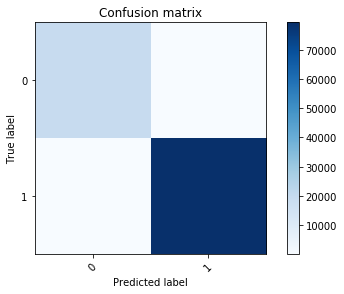

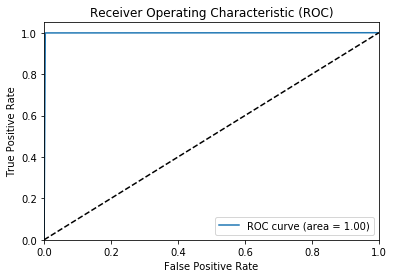

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



In [114]:
from sklearn import metrics
y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
cm = confusion_matrix(y_true, pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(pred,y_true)
print(classification_report(y_true, pred))

# Model Checkpointing and Early Stopping, Saving and Loading Best Weights

In [118]:
batch_size = 64
rows, cols = 1, 122
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_fairclass.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (rows, cols, 1)
    model.add(Conv2D(64, kernel_size=(1, 10), strides=(1, 1),activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(128, (1, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 10), strides=None))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    start_time = time.time()
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train[0:5000], y_train[0:5000],batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test, y_test),callbacks=[monitor,checkpointer])
    
    #model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=10)  
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 1, 113, 64)        704       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 56, 64)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 53, 128)        32896     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 5, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              656384    
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
__________

Accuracy: 0.9960527913849642
Averaged F1: 0.996050242488511
[[19140   228]
 [  162 79274]]
Plotting confusion matrix


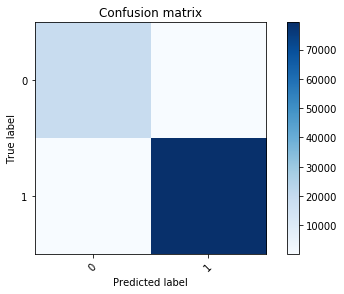

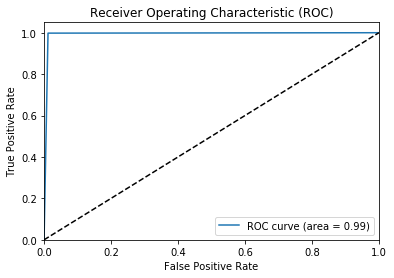

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



In [119]:
from sklearn import metrics

model.load_weights('cnn/best_weights_fairclass.hdf5')
y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
cm = confusion_matrix(y_true, pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(pred,y_true)
print(classification_report(y_true, pred))

# Hypertuning of Parameters on CNN

In [120]:
batch_size = 32
rows, cols = 1, 122
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_fairclass1.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (rows, cols, 1)
    model.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1),activation='tanh',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(1,3)))
    model.add(Conv2D(128, (1, 5), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(1,3), strides=None))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="sgd")
    start_time = time.time()
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train[0:6000], y_train[0:6000],batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test[0:600], y_test[0:600]),callbacks=[monitor,checkpointer])
    
    #model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=10)  
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 1, 118, 32)        192       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 39, 32)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 35, 128)        20608     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 11, 128)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1408)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               721408    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
__________

Accuracy: 0.9883333333333333
Averaged F1: 0.9883523366960928
[[113   3]
 [  4 480]]
Plotting confusion matrix


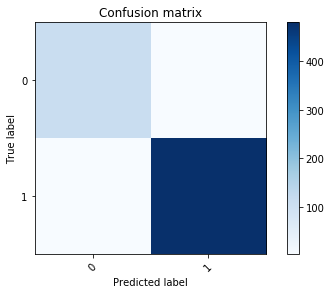

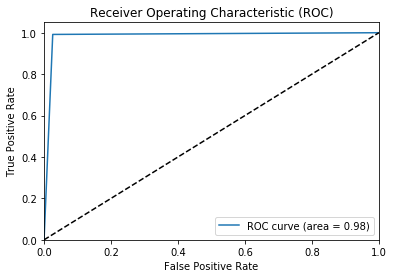

             precision    recall  f1-score   support

          0       0.97      0.97      0.97       116
          1       0.99      0.99      0.99       484

avg / total       0.99      0.99      0.99       600



In [121]:
from sklearn import metrics

model.load_weights('cnn/best_weights_fairclass1.hdf5')
y_true = np.argmax(y_test[0:600],axis=1)
pred = model.predict(x_test[0:600])
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
cm = confusion_matrix(y_true, pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(pred,y_true)
print(classification_report(y_true, pred))

Train on 6000 samples, validate on 600 samples
Epoch 1/3
6000/6000 [==============================] - 144s 24ms/step - loss: 3.1929 - val_loss: 3.1162
Epoch 2/3
6000/6000 [==============================] - 142s 24ms/step - loss: 3.2344 - val_loss: 3.1162
Epoch 3/3
6000/6000 [==============================] - 144s 24ms/step - loss: 3.2344 - val_loss: 3.1162
Train on 6000 samples, validate on 600 samples
Epoch 1/3
6000/6000 [==============================] - 143s 24ms/step - loss: 3.1783 - val_loss: 3.1162
Epoch 2/3
6000/6000 [==============================] - 144s 24ms/step - loss: 3.2344 - val_loss: 3.1162
Epoch 3/3
6000/6000 [==============================] - 143s 24ms/step - loss: 3.2344 - val_loss: 3.1162
Elapsed time: 0:07:10.21
Accuracy: 0.8066666666666666
Averaged F1: 0.7203444034440345
[[  0 116]
 [  0 484]]
Plotting confusion matrix


C:\Users\rutwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


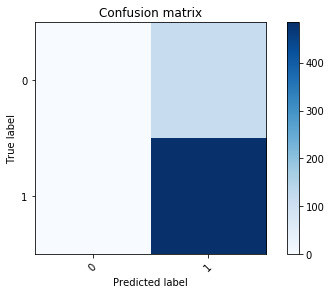

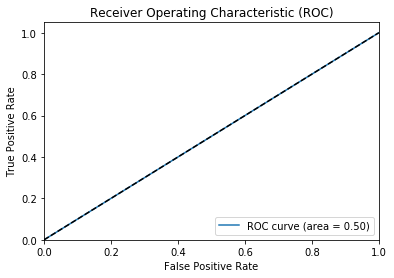

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       116
          1       0.81      1.00      0.89       484

avg / total       0.65      0.81      0.72       600



C:\Users\rutwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [122]:
batch_size = 128
rows, cols = 1, 122
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_fairclass2.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (rows, cols, 1)
    model.add(Conv2D(32, kernel_size=(1, 6), strides=(1, 1),activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(128, (1, 6), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
    start_time = time.time()
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train[0:6000], y_train[0:6000],batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test[0:600], y_test[0:600]),callbacks=[monitor,checkpointer])
    
    
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.load_weights('cnn/best_weights_fairclass2.hdf5')
y_true = np.argmax(y_test[0:600],axis=1)
pred = model.predict(x_test[0:600])
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
cm = confusion_matrix(y_true, pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(pred,y_true)
print(classification_report(y_true, pred))

Train on 6000 samples, validate on 600 samples
Epoch 1/3
6000/6000 [==============================] - 144s 24ms/step - loss: 0.0658 - val_loss: 0.0081
Epoch 2/3
6000/6000 [==============================] - 143s 24ms/step - loss: 0.0166 - val_loss: 0.0092
Epoch 3/3
6000/6000 [==============================] - 142s 24ms/step - loss: 0.0173 - val_loss: 0.0109
Train on 6000 samples, validate on 600 samples
Epoch 1/3
6000/6000 [==============================] - 143s 24ms/step - loss: 0.0641 - val_loss: 0.0116
Epoch 2/3
6000/6000 [==============================] - 143s 24ms/step - loss: 0.0164 - val_loss: 0.0119
Epoch 3/3
6000/6000 [==============================] - 143s 24ms/step - loss: 0.0174 - val_loss: 0.0452
Elapsed time: 0:07:09.38
Accuracy: 0.9983333333333333
Averaged F1: 0.998330585822846
[[115   1]
 [  0 484]]
Plotting confusion matrix


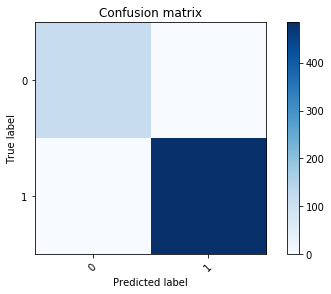

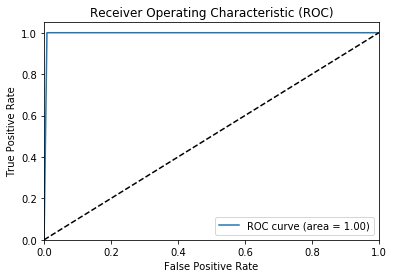

             precision    recall  f1-score   support

          0       1.00      0.99      1.00       116
          1       1.00      1.00      1.00       484

avg / total       1.00      1.00      1.00       600



In [123]:
batch_size = 64
rows, cols = 1, 122
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_fairclass3.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (rows, cols, 1)
    model.add(Conv2D(64, kernel_size=(1, 8), strides=(1, 1),activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(128, (1, 8), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    start_time = time.time()
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train[0:6000], y_train[0:6000],batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test[0:600], y_test[0:600]),callbacks=[monitor,checkpointer])
    
    
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.load_weights('cnn/best_weights_fairclass3.hdf5')
y_true = np.argmax(y_test[0:600],axis=1)
pred = model.predict(x_test[0:600])
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
cm = confusion_matrix(y_true, pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(pred,y_true)
print(classification_report(y_true, pred))

Train on 6000 samples, validate on 600 samples
Epoch 1/3
6000/6000 [==============================] - 143s 24ms/step - loss: 0.5740 - val_loss: 0.4686
Epoch 2/3
6000/6000 [==============================] - 145s 24ms/step - loss: 0.5182 - val_loss: 0.4397
Epoch 3/3
6000/6000 [==============================] - 139s 23ms/step - loss: 0.4903 - val_loss: 0.4230
Train on 6000 samples, validate on 600 samples
Epoch 1/3
6000/6000 [==============================] - 144s 24ms/step - loss: 0.5659 - val_loss: 0.4615
Epoch 2/3
6000/6000 [==============================] - 142s 24ms/step - loss: 0.5276 - val_loss: 0.4341
Epoch 3/3
6000/6000 [==============================] - 142s 24ms/step - loss: 0.4922 - val_loss: 0.4010
Elapsed time: 0:07:09.07
Accuracy: 0.8066666666666666
Averaged F1: 0.7203444034440345
[[  0 116]
 [  0 484]]
Plotting confusion matrix


C:\Users\rutwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


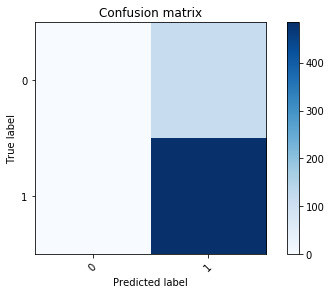

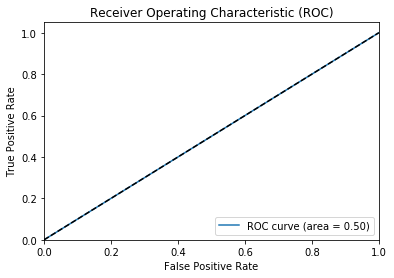

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       116
          1       0.81      1.00      0.89       484

avg / total       0.65      0.81      0.72       600



C:\Users\rutwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [125]:
batch_size = 64
rows, cols = 1, 122
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_fairclass4.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (rows, cols, 1)
    model.add(Conv2D(32, kernel_size=(1, 8), strides=(1, 1),activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(64, (1, 8), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="sgd")
    start_time = time.time()
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train[0:6000], y_train[0:6000],batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test[0:600], y_test[0:600]),callbacks=[monitor,checkpointer])
    
    
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.load_weights('cnn/best_weights_fairclass4.hdf5')
y_true = np.argmax(y_test[0:600],axis=1)
pred = model.predict(x_test[0:600])
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
cm = confusion_matrix(y_true, pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(pred,y_true)
print(classification_report(y_true, pred))

Train on 6000 samples, validate on 600 samples
Epoch 1/3
6000/6000 [==============================] - 151s 25ms/step - loss: 0.0602 - val_loss: 0.0098
Epoch 2/3
6000/6000 [==============================] - 147s 25ms/step - loss: 0.0168 - val_loss: 0.0144
Epoch 3/3
6000/6000 [==============================] - 148s 25ms/step - loss: 0.0150 - val_loss: 0.0056
Train on 6000 samples, validate on 600 samples
Epoch 1/3
6000/6000 [==============================] - 153s 25ms/step - loss: 0.0520 - val_loss: 0.0178
Epoch 2/3
6000/6000 [==============================] - 153s 25ms/step - loss: 0.0211 - val_loss: 0.0044
Epoch 3/3
6000/6000 [==============================] - 152s 25ms/step - loss: 0.0175 - val_loss: 0.0069
Elapsed time: 0:07:38.37
Accuracy: 0.9966666666666667
Averaged F1: 0.9966774610252871
[[116   0]
 [  2 482]]
Plotting confusion matrix


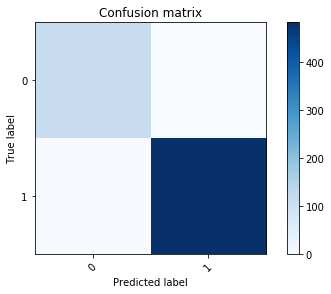

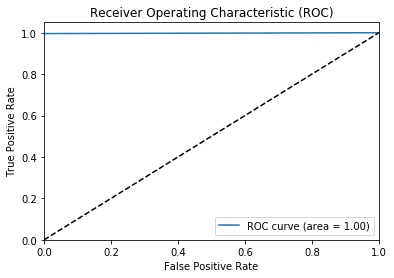

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       116
          1       1.00      1.00      1.00       484

avg / total       1.00      1.00      1.00       600



In [126]:
batch_size = 32
rows, cols = 1, 122
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_fairclass5.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (rows, cols, 1)
    model.add(Conv2D(128, kernel_size=(1, 6), strides=(1, 1),activation='tanh',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(256, (1, 6), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    start_time = time.time()
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train[0:6000], y_train[0:6000],batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test[0:600], y_test[0:600]),callbacks=[monitor,checkpointer])
    
    
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.load_weights('cnn/best_weights_fairclass5.hdf5')
y_true = np.argmax(y_test[0:600],axis=1)
pred = model.predict(x_test[0:600])
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
cm = confusion_matrix(y_true, pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
plot_roc(pred,y_true)
print(classification_report(y_true, pred))